In [236]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import svm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from scipy.spatial import distance

from __future__ import print_function
import argparse
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [237]:
import os
os.getcwd()

'/content'

In [238]:
def readIn(filePath, train):
  with open(filePath) as f:
      lines = f.readlines()
  

  e = pd.DataFrame({"sample": lines})


  e["id"] = e["sample"].str.split('\t').str[0]
  e["sentence_1"] = e["sample"].str.split('\t').str[1]
  e["sentence_2"] = e["sample"].str.split('\t').str[2]

  # PUNCTUATION
  e["sentence_1"] = e["sentence_1"].str.replace(r'[^\w\s]', '', regex=True)
  e["sentence_2"] = e["sentence_2"].str.replace(r'[^\w\s]', '', regex=True)

  # STRIP
  e["sentence_1"] = e["sentence_1"].str.strip()
  e["sentence_2"] = e["sentence_2"].str.strip()

  if(train):
    e["golden_label"] = e["sample"].str.split('\t').str[3]
    e["golden_label"] = e["golden_label"].str.split('\n').str[0]
    e["golden_label"] = pd.to_numeric(e["golden_label"])
    e = e.filter(['id','sentence_1', 'sentence_2', 'golden_label'], axis=1)
    return e

  e = e.filter(['id','sentence_1', 'sentence_2'], axis=1)
  return e



# Euclidean Distance : https://nikoskalikis.medium.com/text-similarity-euclidian-distance-vs-cosine-similarity-3a1167f686a
def euclideanDistance(sentence1, sentence2):

    texts = [sentence1, sentence2]
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    matrix = count_vectorizer.fit_transform(texts)

    table = matrix.todense()
    df = pd.DataFrame(table, 
                      columns=count_vectorizer.get_feature_names(), 
                      index=['sentence_1', 'sentence_2'])
    
    dist = distance.euclidean(df.iloc[0].to_list(), df.iloc[1].to_list())

    return dist

# Cosine similarity: https://nikoskalikis.medium.com/text-similarity-euclidian-distance-vs-cosine-similarity-3a1167f686a
def cosineSim(sentence1, sentence2):
  texts = [sentence1, sentence2]
  count_vectorizer = CountVectorizer(stop_words='english')
  count_vectorizer = CountVectorizer()
  matrix = count_vectorizer.fit_transform(texts)

  table = matrix.todense()
  df = pd.DataFrame(table, columns=count_vectorizer.get_feature_names(), index=['sentence_1', 'sentence_2'])
  
  values = cosine_similarity(df, df)
  return values[0][1]


# Containment value based on n-gram value : https://github.com/Supearnesh/ml-plagiarism-svm#part-b---longest-common-subsequence-lcs:~:text=Text%20(S).-,Part%20A%20%2D%20Containment,-The%20first%20task
def calculateContainment(sentence1, sentence2, n):

    counts = CountVectorizer(analyzer='word', ngram_range=(n,n))
    ngrams = counts.fit_transform([sentence1, sentence2])
    ngram_array = ngrams.toarray()
    intersection_list = np.amin(ngram_array, axis=0)
    intersection = np.sum(intersection_list)

    answer_idx = 0
    answer_cnt = np.sum(ngram_array[answer_idx])

    containment_val =  intersection / answer_cnt

    return containment_val


# LCS : https://github.com/Supearnesh/ml-plagiarism-svm#part-b---longest-common-subsequence-lcs:~:text=answer_cnt%0A%0A%20%20%20%20return%20containment_val-,Part%20B%20%2D%20Longest%20Common%20Subsequence%20(LCS),-Containment%20a%20good
def lcsNorm(sentence1, sentence2):
    a_text = sentence1.split()
    s_text = sentence2.split()
    
    n = len(a_text)
    m = len(s_text)
    
    matrix_lcs = np.zeros((m+1,n+1), dtype=int)
    
    for i, s_word in enumerate(s_text, start=1):
        for j, a_word in enumerate(a_text, start=1):

            if a_word == s_word:
                matrix_lcs[i][j] = matrix_lcs[i-1][j-1] + 1
            else:
                matrix_lcs[i][j] = max(matrix_lcs[i-1][j], matrix_lcs[i][j-1])
    
    normalized_lcs = matrix_lcs[m][n] / n

    return normalized_lcs

# Minimum editing distance : https://github.com/SannyZhou/WURAE_Paraphrase_Identification_CNN_LSTM/blob/master/code/new_features.py#:~:text=def%20minimumEditDistance(str_a%2C%20str_b)%3A
def minimumEditDistance(sentence1, sentence2):
    lensum = float(len(sentence1) + len(sentence2))
    if len(sentence1) > len(sentence2):
        sentence1, sentence2 = sentence2, sentence1
    distances = range(len(sentence1) + 1)
    for index2, char2 in enumerate(sentence2):
        newDistances = [index2 + 1]
        for index1, char1 in enumerate(sentence1):
            if char1 == char2:
                newDistances.append(distances[index1])
            else:
                newDistances.append(1 + min((distances[index1], 
                                             distances[index1 + 1], 
                                             newDistances[-1])))  
        distances = newDistances
    mindist = distances[-1]
    ratio = (lensum - mindist) / lensum
    return ratio

# Word counts / ratios : https://www.kaggle.com/code/akshat4112/quora-question-pair-similarity-part-1-basic-eda?scriptVersionId=93957013&cellId=29 :
# words shared between two sentences
def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['sentence_1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence_2'].split(" ")))    
    return 1.0 * len(w1 & w2)

# words in total between two sentences
def normalized_word_total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['sentence_1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence_2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))

# words shared / total words 
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['sentence_1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['sentence_2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

def createFeatures(data_f, train):
  features = pd.DataFrame()
  if(train):
    features["golden_label"] = data_f["golden_label"]

  features['sentence1_len'] = data_f.apply(lambda x: len(x.sentence_1), axis=1)
  features['sentence2_len'] = data_f.apply(lambda x: len(x.sentence_2), axis=1)
  features['sentence_len_diff'] = data_f.apply(lambda x: abs(len(x.sentence_1)-len(x.sentence_2)), axis=1)

  features['sentence1_words'] = data_f['sentence_1'].apply(lambda row: len(row.split(" ")))
  features['sentence2_words'] = data_f['sentence_2'].apply(lambda row: len(row.split(" ")))

  features['word_common'] = data_f.apply(lambda x: normalized_word_common(x), axis=1)
  features['word_total'] = data_f.apply(lambda x: normalized_word_total(x), axis=1)
  features['word_share'] = features.apply(lambda x: x.word_common / x.word_total, axis=1)

  features['minimumED'] = data_f.apply(lambda x: minimumEditDistance(x.sentence_1, x.sentence_2), axis=1)
  features['euclid_dist'] = data_f.apply(lambda x: euclideanDistance(x.sentence_1, x.sentence_2), axis=1)
  features['cos_sim'] = data_f.apply(lambda x: cosineSim(x.sentence_1, x.sentence_2), axis=1)
  features['lcsNorm'] = data_f.apply(lambda x: lcsNorm(x.sentence_1, x.sentence_2), axis=1)


  n_range = 6
  for i in range(1, n_range):
      column_name = "containment_" + str(i)
      print(column_name)
      features[column_name] = data_f.apply(lambda x: calculateContainment(x.sentence_1, x.sentence_2, i), axis=1)
  return features



In [239]:
trainF = readIn('/4526Data/final/train_with_label.txt', True)
devF = readIn('/4526Data/final/dev_with_label.txt', True)
testF = readIn('/4526Data/final/test_without_label.txt', False)


In [240]:
# Create features and display /FINAL
trainFeaturesF = createFeatures(trainF, True)
devFeaturesF = createFeatures(devF, True)
testFeaturesF = createFeatures(testF, False)

display(trainFeaturesF)
display(devFeaturesF)
display(testFeaturesF)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_

containment_1
containment_2
containment_3
containment_4
containment_5


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_

containment_1
containment_2
containment_3
containment_4
containment_5


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_

containment_1
containment_2
containment_3
containment_4
containment_5


,golden_label,sentence1_len,sentence2_len,sentence_len_diff,sentence1_words,sentence2_words,word_common,word_total,word_share,minimumED,euclid_dist,cos_sim,lcsNorm,containment_1,containment_2,containment_3,containment_4,containment_5
0,0,116,88,28,23,16,3.0,33.0,0.090909,0.553922,5.477226,0.255155,0.100000,0.150,0.000000,0.000000,0.000000,0.000000
1,0,121,222,101,22,43,21.0,58.0,0.362069,0.705539,4.000000,0.781548,1.000000,1.000,1.000000,1.000000,1.000000,1.000000
2,0,136,136,0,26,26,22.0,44.0,0.500000,0.606618,0.000000,1.000000,0.217391,1.000,0.000000,0.000000,0.000000,0.000000
3,0,112,215,103,23,46,21.0,59.0,0.355932,0.685015,4.123106,0.744323,1.000000,1.000,1.000000,1.000000,1.000000,1.000000
4,0,186,68,118,28,15,2.0,40.0,0.050000,0.413386,6.480741,0.049814,0.038462,0.040,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,1,78,96,18,17,17,9.0,32.0,0.281250,0.660920,3.605551,0.518875,0.400000,0.500,0.153846,0.083333,0.000000,0.000000
7797,0,117,239,122,19,47,18.0,56.0,0.321429,0.657303,4.582576,0.711057,1.000000,1.000,1.000000,1.000000,1.000000,1.000000
7798,0,82,82,0,18,18,15.0,30.0,0.500000,0.585366,0.000000,1.000000,0.071429,1.000,0.000000,0.000000,0.000000,0.000000
7799,1,91,130,39,19,27,11.0,32.0,0.343750,0.791855,3.872983,0.809345,0.823529,0.875,0.733333,0.642857,0.538462,0.416667


,golden_label,sentence1_len,sentence2_len,sentence_len_diff,sentence1_words,sentence2_words,word_common,word_total,word_share,minimumED,euclid_dist,cos_sim,lcsNorm,containment_1,containment_2,containment_3,containment_4,containment_5
0,0,170,229,59,28,43,24.0,58.0,0.413793,0.852130,2.828427,0.904903,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0,95,137,42,18,22,2.0,37.0,0.054054,0.547414,5.916080,0.054233,0.058824,0.066667,0.000000,0.000000,0.000000,0.000000
2,0,125,209,84,25,46,20.0,55.0,0.363636,0.748503,4.000000,0.820901,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0,181,315,134,28,53,25.0,70.0,0.357143,0.729839,4.472136,0.790724,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1,94,129,35,15,20,13.0,34.0,0.382353,0.780269,3.000000,0.770675,0.866667,0.866667,0.714286,0.538462,0.333333,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,153,96,57,29,21,6.0,44.0,0.136364,0.558233,5.916080,0.192450,0.107143,0.160000,0.000000,0.000000,0.000000,0.000000
3996,1,115,93,22,21,18,13.0,34.0,0.382353,0.740385,3.162278,0.753735,0.526316,0.631579,0.500000,0.411765,0.312500,0.266667
3997,0,118,208,90,18,33,18.0,50.0,0.360000,0.723926,3.605551,0.752773,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3998,1,155,156,1,29,30,18.0,54.0,0.333333,0.707395,4.242641,0.689655,0.666667,0.666667,0.500000,0.400000,0.291667,0.260870


,sentence1_len,sentence2_len,sentence_len_diff,sentence1_words,sentence2_words,word_common,word_total,word_share,minimumED,euclid_dist,cos_sim,lcsNorm,containment_1,containment_2,containment_3,containment_4,containment_5
0,97,97,0,19,19,16.0,32.0,0.500000,0.623711,0.000000,1.000000,0.066667,1.000000,0.000000,0.000000,0.000,0.000000
1,92,92,0,16,16,16.0,32.0,0.500000,0.608696,0.000000,1.000000,0.066667,1.000000,0.000000,0.000000,0.000,0.000000
2,81,88,7,15,18,9.0,28.0,0.321429,0.881657,3.316625,0.737865,0.642857,0.692308,0.583333,0.454545,0.300,0.222222
3,112,120,8,23,27,19.0,44.0,0.431818,0.918103,2.449490,0.851064,0.900000,0.894737,0.777778,0.647059,0.625,0.600000
4,154,78,76,28,16,3.0,36.0,0.083333,0.478448,6.928203,0.133631,0.038462,0.076923,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,86,218,132,22,46,16.0,51.0,0.313725,0.565789,4.582576,0.694022,1.000000,1.000000,1.000000,1.000000,1.000,1.000000
3996,123,56,67,23,11,1.0,32.0,0.031250,0.452514,5.291503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3997,146,251,105,27,45,24.0,64.0,0.375000,0.735516,4.000000,0.829943,1.000000,1.000000,1.000000,1.000000,1.000,1.000000
3998,143,301,158,24,55,22.0,64.0,0.343750,0.644144,6.480741,0.674161,1.000000,1.000000,1.000000,1.000000,1.000,1.000000


In [241]:
selected_features = ["golden_label","lcsNorm", "minimumED", "containment_1","containment_3","sentence1_len", "sentence2_len", "sentence_len_diff", "euclid_dist", "cos_sim", "word_common", "word_total", "word_share", "sentence1_words", "sentence2_words"]
selected_featuresTest = ["lcsNorm", "minimumED", "containment_1","containment_3","sentence1_len", "sentence2_len", "sentence_len_diff", "euclid_dist", "cos_sim", "word_common", "word_total", "word_share", "sentence1_words", "sentence2_words"]

trainFeaturesUF = trainFeaturesF.filter(selected_features, axis=1)
devFeaturesUF = devFeaturesF.filter(selected_features, axis=1)
testFeaturesUF = testFeaturesF.filter(selected_featuresTest, axis=1)

In [242]:
trainFeaturesUF.to_csv("/4526Data/finalFeatures/train.csv", index=False)
devFeaturesUF.to_csv("/4526Data/finalFeatures/dev.csv", index=False)
testFeaturesUF.to_csv("/4526Data/finalFeatures/test.csv", index=False)


### Run From Here:
- If finalFeatures folder is imported, run everything after this cell

In [243]:
# PyTorch install
# https://discuss.pytorch.org/t/google-colab-runtimeerror-cuda-error-device-side-assert-triggered/69559
# need to change to 1? helps with debugging, else it's not very clear what the error is 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
!pip3 install torch torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [244]:
trainFeaturesUF = pd.read_csv('/4526Data/finalFeatures/train.csv')
devFeaturesUF = pd.read_csv('/4526Data/finalFeatures/dev.csv')
testFeaturesUF = pd.read_csv('/4526Data/finalFeatures/test.csv')


In [245]:
train_y = trainFeaturesUF.iloc[:,0]
train_x = trainFeaturesUF.iloc[:,1:]

smote = SMOTE(sampling_strategy='minority', random_state=27)
train_x, train_y = smote.fit_resample(train_x, train_y)


# SUPER important, don't forget to normalize the testing and training data before putting it into the model 
normalizer = StandardScaler()
train_x = normalizer.fit_transform(train_x)
dev_x = normalizer.fit_transform(devFeaturesUF.drop('golden_label', axis=1).values)


In [246]:
# Training data 
train_target = torch.Tensor(train_y.values)
train_features = torch.Tensor(train_x)

dev_target = torch.Tensor(devFeaturesUF['golden_label'].values)
dev_features = torch.Tensor(dev_x)

train_target = train_target.type(torch.int64)
dev_target = dev_target.type(torch.int64)

train = torch.utils.data.TensorDataset(train_features, train_target)
dev = torch.utils.data.TensorDataset(dev_features, dev_target)

In [247]:
args={}
args['batch_size']=75

# make sure test batch size is ONE or else when using model on testing data, the output will be samplesize / batch size, so instead of 4000 predictions youll get 125 predictions (if the batch size is 32, for ex)
args['test_batch_size']=1
args['epochs']=20 #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['log_interval']=10

In [248]:

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.hid1 = nn.Linear(14, 32)  
        self.drop1 = nn.Dropout(0.50)
        self.hid2 = nn.Linear(32, 64)
        self.drop2 = nn.Dropout(0.25)
        self.oupt = nn.Linear(64, 1)
        
    def forward(self, x):
          z = torch.tanh(self.hid1(x)) 
          z = self.drop1(z)
          z = torch.tanh(self.hid2(z))
          z = self.drop2(z)
          z = torch.sigmoid(self.oupt(z)) 
          return z

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.layer_1 = nn.Linear(14, 300) 
        self.layer_2 = nn.Linear(300, 100)
        # https://stackoverflow.com/questions/61968540/ret-torch-c-nn-nll-lossinput-target-weight-reduction-get-enumreduction
        self.layer_out = nn.Linear(100, 1) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(300)
        self.batchnorm2 = nn.BatchNorm1d(100)


        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x


class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
    

        self.fc1 = nn.Linear(14,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.layer_1 = nn.Linear(14, 256)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity='relu')
        self.layer_2 = nn.Linear(256, 128)
        nn.init.kaiming_uniform_(self.layer_2.weight, nonlinearity='relu')
        self.layer_3 = nn.Linear(128, 64)
        nn.init.kaiming_uniform_(self.layer_2.weight, nonlinearity='relu')
        self.layer_out = nn.Linear(64, 1)
        nn.init.xavier_uniform_(self.layer_out.weight)
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x




model = Net3()
print(model)

Net3(
  (layer_1): Linear(in_features=14, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [249]:
criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

In [250]:
# Load the data using pytorch dataloader + Adjust the args batch size and test batch size 
train_loader = torch.utils.data.DataLoader(train, batch_size=args['batch_size'], shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev, batch_size=args['test_batch_size'], shuffle=False)

In [251]:
def train(epoch):
    # tell model to start training
    model.train()

    # Batch training - capture batch from training data? 
    for batch_idx, (data, target) in enumerate(train_loader):
        # # need to convert target type to int64 since the values are 1 or 0. Will error if not converted 
      
        output = model(data)
        target = target.unsqueeze(1)
        output = output.type(torch.float32)
        target = target.type(torch.float32)
        loss = criterion(output, target)

        train_losses.append(loss.cpu().detach().numpy())

        # compute gradients
        optimizer.zero_grad()

        # Back propogation
        loss.backward()

        # to do a one-step update on our parameter.
        optimizer.step()
        
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [253]:
# Initialize lists to gather training losses and testing accuracies
train_losses = []
# test_acc=[]
for epoch in range(1, args['epochs'] + 1):
    train(epoch)

Train Epoch: 1 [0/11802 (0%)]	Loss: 0.591364
Train Epoch: 1 [750/11802 (6%)]	Loss: 0.293469
Train Epoch: 1 [1500/11802 (13%)]	Loss: 0.257115
Train Epoch: 1 [2250/11802 (19%)]	Loss: 0.286614
Train Epoch: 1 [3000/11802 (25%)]	Loss: 0.310984
Train Epoch: 1 [3750/11802 (32%)]	Loss: 0.183719
Train Epoch: 1 [4500/11802 (38%)]	Loss: 0.211047
Train Epoch: 1 [5250/11802 (44%)]	Loss: 0.257252
Train Epoch: 1 [6000/11802 (51%)]	Loss: 0.203732
Train Epoch: 1 [6750/11802 (57%)]	Loss: 0.186471
Train Epoch: 1 [7500/11802 (63%)]	Loss: 0.151017
Train Epoch: 1 [8250/11802 (70%)]	Loss: 0.143322
Train Epoch: 1 [9000/11802 (76%)]	Loss: 0.202896
Train Epoch: 1 [9750/11802 (82%)]	Loss: 0.136452
Train Epoch: 1 [10500/11802 (89%)]	Loss: 0.159512
Train Epoch: 1 [11250/11802 (95%)]	Loss: 0.233915
Train Epoch: 2 [0/11802 (0%)]	Loss: 0.159930
Train Epoch: 2 [750/11802 (6%)]	Loss: 0.183140
Train Epoch: 2 [1500/11802 (13%)]	Loss: 0.224755
Train Epoch: 2 [2250/11802 (19%)]	Loss: 0.161926
Train Epoch: 2 [3000/11802 (25

Text(0, 0.5, 'Training Loss')

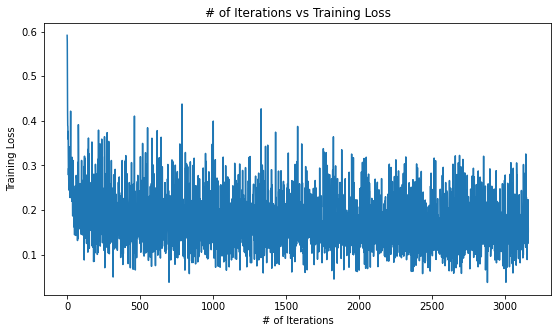

In [254]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

plt.subplot(1,2,2)
plt.title('# of Iterations vs Training Loss')
plt.plot(train_losses)
plt.xlabel('# of Iterations')
plt.ylabel('Training Loss')

In [256]:
def testwithLoader(loader):

  y_pred_list = []
  model.eval()
  with torch.no_grad():
      for X_batch,yb_test in loader:
          y_test_pred = model(X_batch)
          y_pred_tag = torch.round(y_test_pred)
          y_pred_list.append(y_pred_tag.cpu().numpy())

  return [a.squeeze().tolist() for a in y_pred_list]

In [257]:


dev_y = devFeaturesUF['golden_label'].values
dev_pred = testwithLoader(dev_loader)

conf_matrix = confusion_matrix(dev_y, dev_pred)
print("Confusion Matrix of the Dev Set")
print("-----------")
print(conf_matrix)
print("-----------\n")
print(classification_report(dev_y, dev_pred))

Confusion Matrix of the Dev Set
-----------
[[2531  469]
 [   9  991]]
-----------

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3000
           1       0.68      0.99      0.81      1000

    accuracy                           0.88      4000
   macro avg       0.84      0.92      0.86      4000
weighted avg       0.92      0.88      0.89      4000



In [258]:
from sklearn.metrics import f1_score

f1_score(dev_y, dev_pred, average='macro'), f1_score(dev_y, dev_pred, average='micro'), f1_score(dev_y, dev_pred,average='weighted'), f1_score(dev_y, dev_pred, average=None), f1_score(dev_y, dev_pred, average='binary')


(0.8597047342314578,
 0.8805,
 0.8867115728919021,
 array([0.91371841, 0.80569106]),
 0.8056910569105691)

In [259]:

df = pd.DataFrame()
df['target'] = dev_y
df['pred'] = np.array(dev_pred).astype(int)
df['correct'] = np.where(df['target'] == df['pred'], True, False)
df['correct'].value_counts()[1] / 4000

0.8805

In [260]:
test_x = testFeaturesUF

# SUPER important, don't forget to normalize the testing and training data before putting it into the model 
test_x = normalizer.fit_transform(test_x)

test_features = torch.Tensor(test_x)

test = torch.utils.data.TensorDataset(test_features, torch.empty((4000,1)))

test_loader = torch.utils.data.DataLoader(test, batch_size=args['test_batch_size'], shuffle=False)

test_pred = testwithLoader(test_loader)


test_pred = np.array(test_pred).astype(int)

In [261]:
prediction = pd.DataFrame()
prediction["instance_id"] = testF['id']
prediction ["predicted_label"] = test_pred

prediction.to_csv('/4526Data/ChristineCho_test_result.txt', sep=' ', index=False, header=False)